# Setup
Loading all the necessary libraries.

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

In [113]:
n_objects = 40

# Helper functions
Here we define the functions that we later use in the proceeding of the notebook.  
You can find here the `img_info_to_part_id` and `rotate_and_crop` functions cited in the report. 

In [114]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))
print(img_info_to_part_id("img01.bmp", "bottom_right"))
print()
print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))
print(img_info_to_part_id("img02.bmp", "bottom_right"))

0
1
2
3

4
5
6
7


In [115]:
def part_id_to_img_info(part_id):
	pid_copy = part_id
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 +1 
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 0:
		location = "top_left"
	elif part_id % 4 == 1:
		location = "bottom_left"
	elif part_id % 4 == 2:
		location = "top_right"
	elif part_id % 4 == 3:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(0))
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print()
print(part_id_to_img_info(4))
print(part_id_to_img_info(5))
print(part_id_to_img_info(6))
print(part_id_to_img_info(7))

('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')

('02', 'top_left')
('02', 'bottom_left')
('02', 'top_right')
('02', 'bottom_right')


In [116]:
cartella_immagini = {
	'originals': './Processed dataset/df old/',
	'rot&crop': './Processed dataset/df new/',
	# other possible folders
}

# in english: generate_image_path
def genera_percorso_immagine(part_id, which_ones="originals",option="seg"):	
	imgnum, location = part_id_to_img_info(part_id)
	real_option = option
	if option=="seg":
		real_option = "segmented"
	else:
		real_option = "labeled"

	nome_immagine = f"img{imgnum}.bmp_{location}_{real_option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(0, "originals"))
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(3, "originals"))

./Processed dataset/df old/img01.bmp_top_left_segmented.png
./Processed dataset/df old/img01.bmp_bottom_left_segmented.png
./Processed dataset/df old/img01.bmp_top_right_segmented.png
./Processed dataset/df old/img01.bmp_bottom_right_segmented.png


In [117]:
def rotate_and_crop(img, rect, verbose=0):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	
	if angle > 45:
		angle = angle - 90
	if verbose == 1:
		print(f"Angle inside function is {angle}")
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	if verbose==1:
		print(rect)
		print(center)
		print(size)
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)

	return img_crop, img_rot

In [118]:
def calculate_curvature(points):
	# Calcola la differenza delle coordinate x e y tra i punti successivi e precedenti
	dx = np.gradient(points[:, 0])
	dy = np.gradient(points[:, 1])

	# Calcola la seconda differenza delle coordinate x e y
	d2x = np.gradient(dx)
	d2y = np.gradient(dy)

	# Calcola la curvatura utilizzando la formula di curvatura
	curvature = (d2x * dy - d2y * dx) / (dx**2 + dy**2)**1.5

	return curvature

In [120]:
def summary_assumptions(data_points,titolo="",plotto=0):
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		plt.hist(data_points)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{titolo}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({titolo}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({titolo}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')

# Dataset manipulation

In [8]:
# call original python script
%run image_analysis_function.py

## df old

In [121]:
df_old = pd.read_csv('./Processed dataset/df old/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_old['Part_ID'] = df_old.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_old['Num_voids'] = df_old.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_old_parts = df_old[df_old['Region type'] == 'part']
df_old_voids = df_old[df_old['Region type'] == 'void']
df_old_parts.reset_index(drop=True, inplace=True)
df_old_voids.reset_index(drop=True, inplace=True)

df_old.head(10)

Image name  Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp  top_left        part   0          39334            3979.892   
1  img01.bmp  top_left        void   1             94              37.556   
2  img01.bmp  top_left        void   2             95              46.142   
3  img01.bmp  top_left        void   3            239              77.527   
4  img01.bmp  top_left        void   4            195              61.420   
5  img01.bmp  top_left        void   5            146              54.770   
6  img01.bmp  top_left        void   6            192              71.835   
7  img01.bmp  top_left        void   7            322              72.770   
8  img01.bmp  top_left        void   8            342              76.184   
9  img01.bmp  top_left        void   9            292              78.912   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.145                 -1.399     0.775   0.658   
1         0.773                  1.445     0.949   0.696   
2         0.935                 -1.466     0.872   0.565   
3         0.942                 -1.432     0.909   0.569   
4         0.885                  1.545     0.907   0.577   
5         0.883                  0.818     0.912   0.477   
6         0.954                 -1.440     0.881   0.529   
7         0.324                  0.429     0.947   0.610   
8         0.498                  0.893     0.927   0.594   
9         0.904                 -0.973     0.927   0.438   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     276.941                     274.023   
1                      14.463                       9.178   
2                      19.647                       6.959   
3                      31.984                      10.699   
4                      24.535                      11.419   
5                      20.885                       9.814   
6                      30.397                       9.124   
7                      22.009                      20.826   
8                      23.752                      20.593   
9                      31.198                      13.312   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  
0                       223.789        0         41  
1                        10.940        0         41  
2                        10.998        0         41  
3                        17.444        0         41  
4                        15.757        0         41  
5                        13.634        0         41  
6                        15.635        0         41  
7                        20.248        0         41  
8                        20.867        0         41  
9                        19.282        0         41

## df_new

In [66]:
output_folder = "./Processed dataset/df new/"
statistics = []

for part_id in range(0,40):
	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Applica il filtro bilaterale per ridurre il rumore
	blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
	# maybe blurred not really needed
	# decide it in the img input to the next function (choose gray or blurred_img)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)

	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)

		img_info = part_id_to_img_info(part_id)
		filename = f"img{img_info[0]}.bmp_{img_info[1]}_segmented.png"
		cv2.imwrite(os.path.join(output_folder, filename), cropped_image) 

		# print(type(cropped_image))
		# plt.figure(figsize=(12, 12))
		# plt.subplot(1,3,1)
		# plt.imshow(cropped_image)
		# plt.axis('off')
		# plt.title("cropped_image")

		# img_pil = Image.fromarray(cropped_image, 'RGB')
		# img_pil = img_pil.convert('L')
		# print(type(img_pil))
		# plt.imshow(img_pil,cmap="gray")
		# plt.axis('off')
		# plt.show()

		# gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
		# (T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
		# labeled_segmented_image = label(threshInv)
	
		image = Image.open(os.path.join(output_folder, filename))
		# Convert the image to grayscale
		image = image.convert('L')
		# # Increase the contrast
		enhancer = ImageEnhance.Contrast(image)
		image = enhancer.enhance(100)
		# width, height = image.size
		# image = image.crop((0,0,width,height))
		image = np.array(image)
		# plt.imshow(image, cmap='gray')
		# plt.axis('off')  # Nasconde gli assi
		# plt.show()
		otsu_thresh = threshold_otsu(image)
		image = image > otsu_thresh

		# Convert the boolean image to an 8-bit unsigned integer image
		# img = (threshInv.astype(np.uint8) * 255)
		img = (image.astype(np.uint8) * 255)
		# Use regionprops to get properties of the region
		part_props = regionprops(img)[0]  # Get the first (and only) region
		# Crop the image with margin around the bounding box
		minr, minc, maxr, maxc = part_props.bbox
		# print(part_props.bbox)
		minr_crop = max(minr + 12, 0)
		minc_crop = max(minc + 12, 0)
		maxr_crop = min(maxr - 12, img.shape[0])
		maxc_crop = min(maxc - 12, img.shape[1])
		padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]
		
		# Invert the padded image
		inv_padded_img = 255 - padded_img
		# plt.subplot(1,3,2)
		# plt.imshow(inv_padded_img,cmap="gray")
		# plt.axis('off')
		# plt.title("inv_padded_img")

		# Apply labeling
		labels = label(inv_padded_img, background=0)
		# props_voids = regionprops(labels)
		# Find the biggest region
		# biggest_region = max(props_voids, key=lambda region: region.area)
		# Set the pixels in the biggest region to 0
		# labels[labels == biggest_region.label] = 0
		# Repeat labeling
		# labels = label(labels, background=0)
		props_voids = regionprops(labels)
		# Create a figure and axes
		plt.figure(figsize=(8, 8))
		fig, ax = plt.subplots()
		# Display the image
		ax.imshow(labels, cmap='nipy_spectral')
		# Annotate label numbers

		for region in regionprops(labels):
			# Get the coordinates of the centroid
			y, x = region.centroid
			# Annotate the label number at the centroid
			ax.text(x, y, str(region.label), color='white')
		# Save the labeled image  		
		labeled_filename = f"img{img_info[0]}.bmp_{img_info[1]}_labeled.png"
		labeled_output_path = os.path.join(output_folder, labeled_filename)
		plt.savefig(labeled_output_path)
		# Close the figure to free up memory
		# plt.show()
		# plt.close()
		plt.close('all')


		# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
		statistics.append({
			"Image name": f"img{img_info[0]}.bmp",
			"Position": img_info[1],
			"Region type": "part",
			"ID": 0,
			"Area [pixels]": round(part_props.area, 3),
			"Perimeter [pixels]": round(part_props.perimeter, 3),
			"Eccentricity": round(part_props.eccentricity, 3),
			"Orientation [radians]": round(part_props.orientation, 3),
			"Solidity": round(part_props.solidity, 3),
			"Extent": round(part_props.extent, 3),
			"Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
			"Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
			"Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3),
			"Part_ID": part_id,
			"Num_voids": len(props_voids)
		})

		old_size = len(statistics)
		# print(f"Old size: {len(statistics)}")

		# Loop over each void
		for i, prop in enumerate(props_voids, start=1):
			# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
			statistics.append({
				"Image name": f"img{img_info[0]}.bmp",
				"Position": img_info[1],
				"Region type": "void",
				"ID": i,
				"Area [pixels]": round(prop.area, 3),
				"Perimeter [pixels]": round(prop.perimeter, 3),
				"Eccentricity": round(prop.eccentricity, 3),
				"Orientation [radians]": round(prop.orientation, 3),
				"Solidity": round(prop.solidity, 3),
				"Extent": round(prop.extent, 3),
				"Major Axis Length [pixels]": round(prop.major_axis_length, 3),
				"Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
				"Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3),
				"Part_ID": part_id,
				"Num_voids": len(props_voids)
			})

		# print(f"Nvoids from props: {len(props_voids)}")
		# print(f"Rows added now: {len(statistics)-old_size}")
		# print(f"Nvoids in df old were: {df_old_parts.iloc[part_id]['Num_voids']}\n")
		if (len(statistics)-old_size) != len(props_voids):
			print("Something strange happened")
			break

# Convert the list of dictionaries to a DataFrame
statistics_df = pd.DataFrame(statistics)
# Export the DataFrame to a CSV file in the output_folder
output_file = os.path.join(output_folder, "image_statistics.csv")
statistics_df.to_csv(output_file, index=False)

In [158]:
df_new = pd.read_csv('./Processed dataset/df new/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_new['Part_ID'] = df_new.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_new['Num_voids'] = df_new.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_new_parts = df_new[df_new['Region type'] == 'part']
df_new_voids = df_new[df_new['Region type'] == 'void']
df_new_parts.reset_index(drop=True, inplace=True)
df_new_voids.reset_index(drop=True, inplace=True)

df_new.head(10)

Image name  Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp  top_left        part   0          38291            4105.674   
1  img01.bmp  top_left        void   1            104              40.142   
2  img01.bmp  top_left        void   2            106              47.799   
3  img01.bmp  top_left        void   3            263              80.355   
4  img01.bmp  top_left        void   4            211              64.006   
5  img01.bmp  top_left        void   5            159              56.355   
6  img01.bmp  top_left        void   6            211              73.077   
7  img01.bmp  top_left        void   7            339              75.841   
8  img01.bmp  top_left        void   8            361              78.184   
9  img01.bmp  top_left        void   9            329              77.770   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.153                 -1.268     0.760   0.743   
1         0.752                 -1.556     0.912   0.693   
2         0.935                 -1.335     0.898   0.589   
3         0.939                 -1.307     0.895   0.501   
4         0.884                 -1.478     0.887   0.601   
5         0.874                  0.932     0.888   0.523   
6         0.951                 -1.313     0.847   0.471   
7         0.326                  0.692     0.929   0.589   
8         0.502                  1.001     0.928   0.602   
9         0.718                  0.249     0.901   0.580   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     277.925                     274.667   
1                      14.874                       9.809   
2                      20.548                       7.293   
3                      32.887                      11.318   
4                      25.354                      11.839   
5                      21.442                      10.408   
6                      31.267                       9.708   
7                      22.505                      21.278   
8                      24.343                      21.051   
9                      26.044                      18.126   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  
0                       220.802        0         41  
1                        11.507        0         41  
2                        11.617        0         41  
3                        18.299        0         41  
4                        16.391        0         41  
5                        14.228        0         41  
6                        16.391        0         41  
7                        20.776        0         41  
8                        21.439        0         41  
9                        20.467        0         41

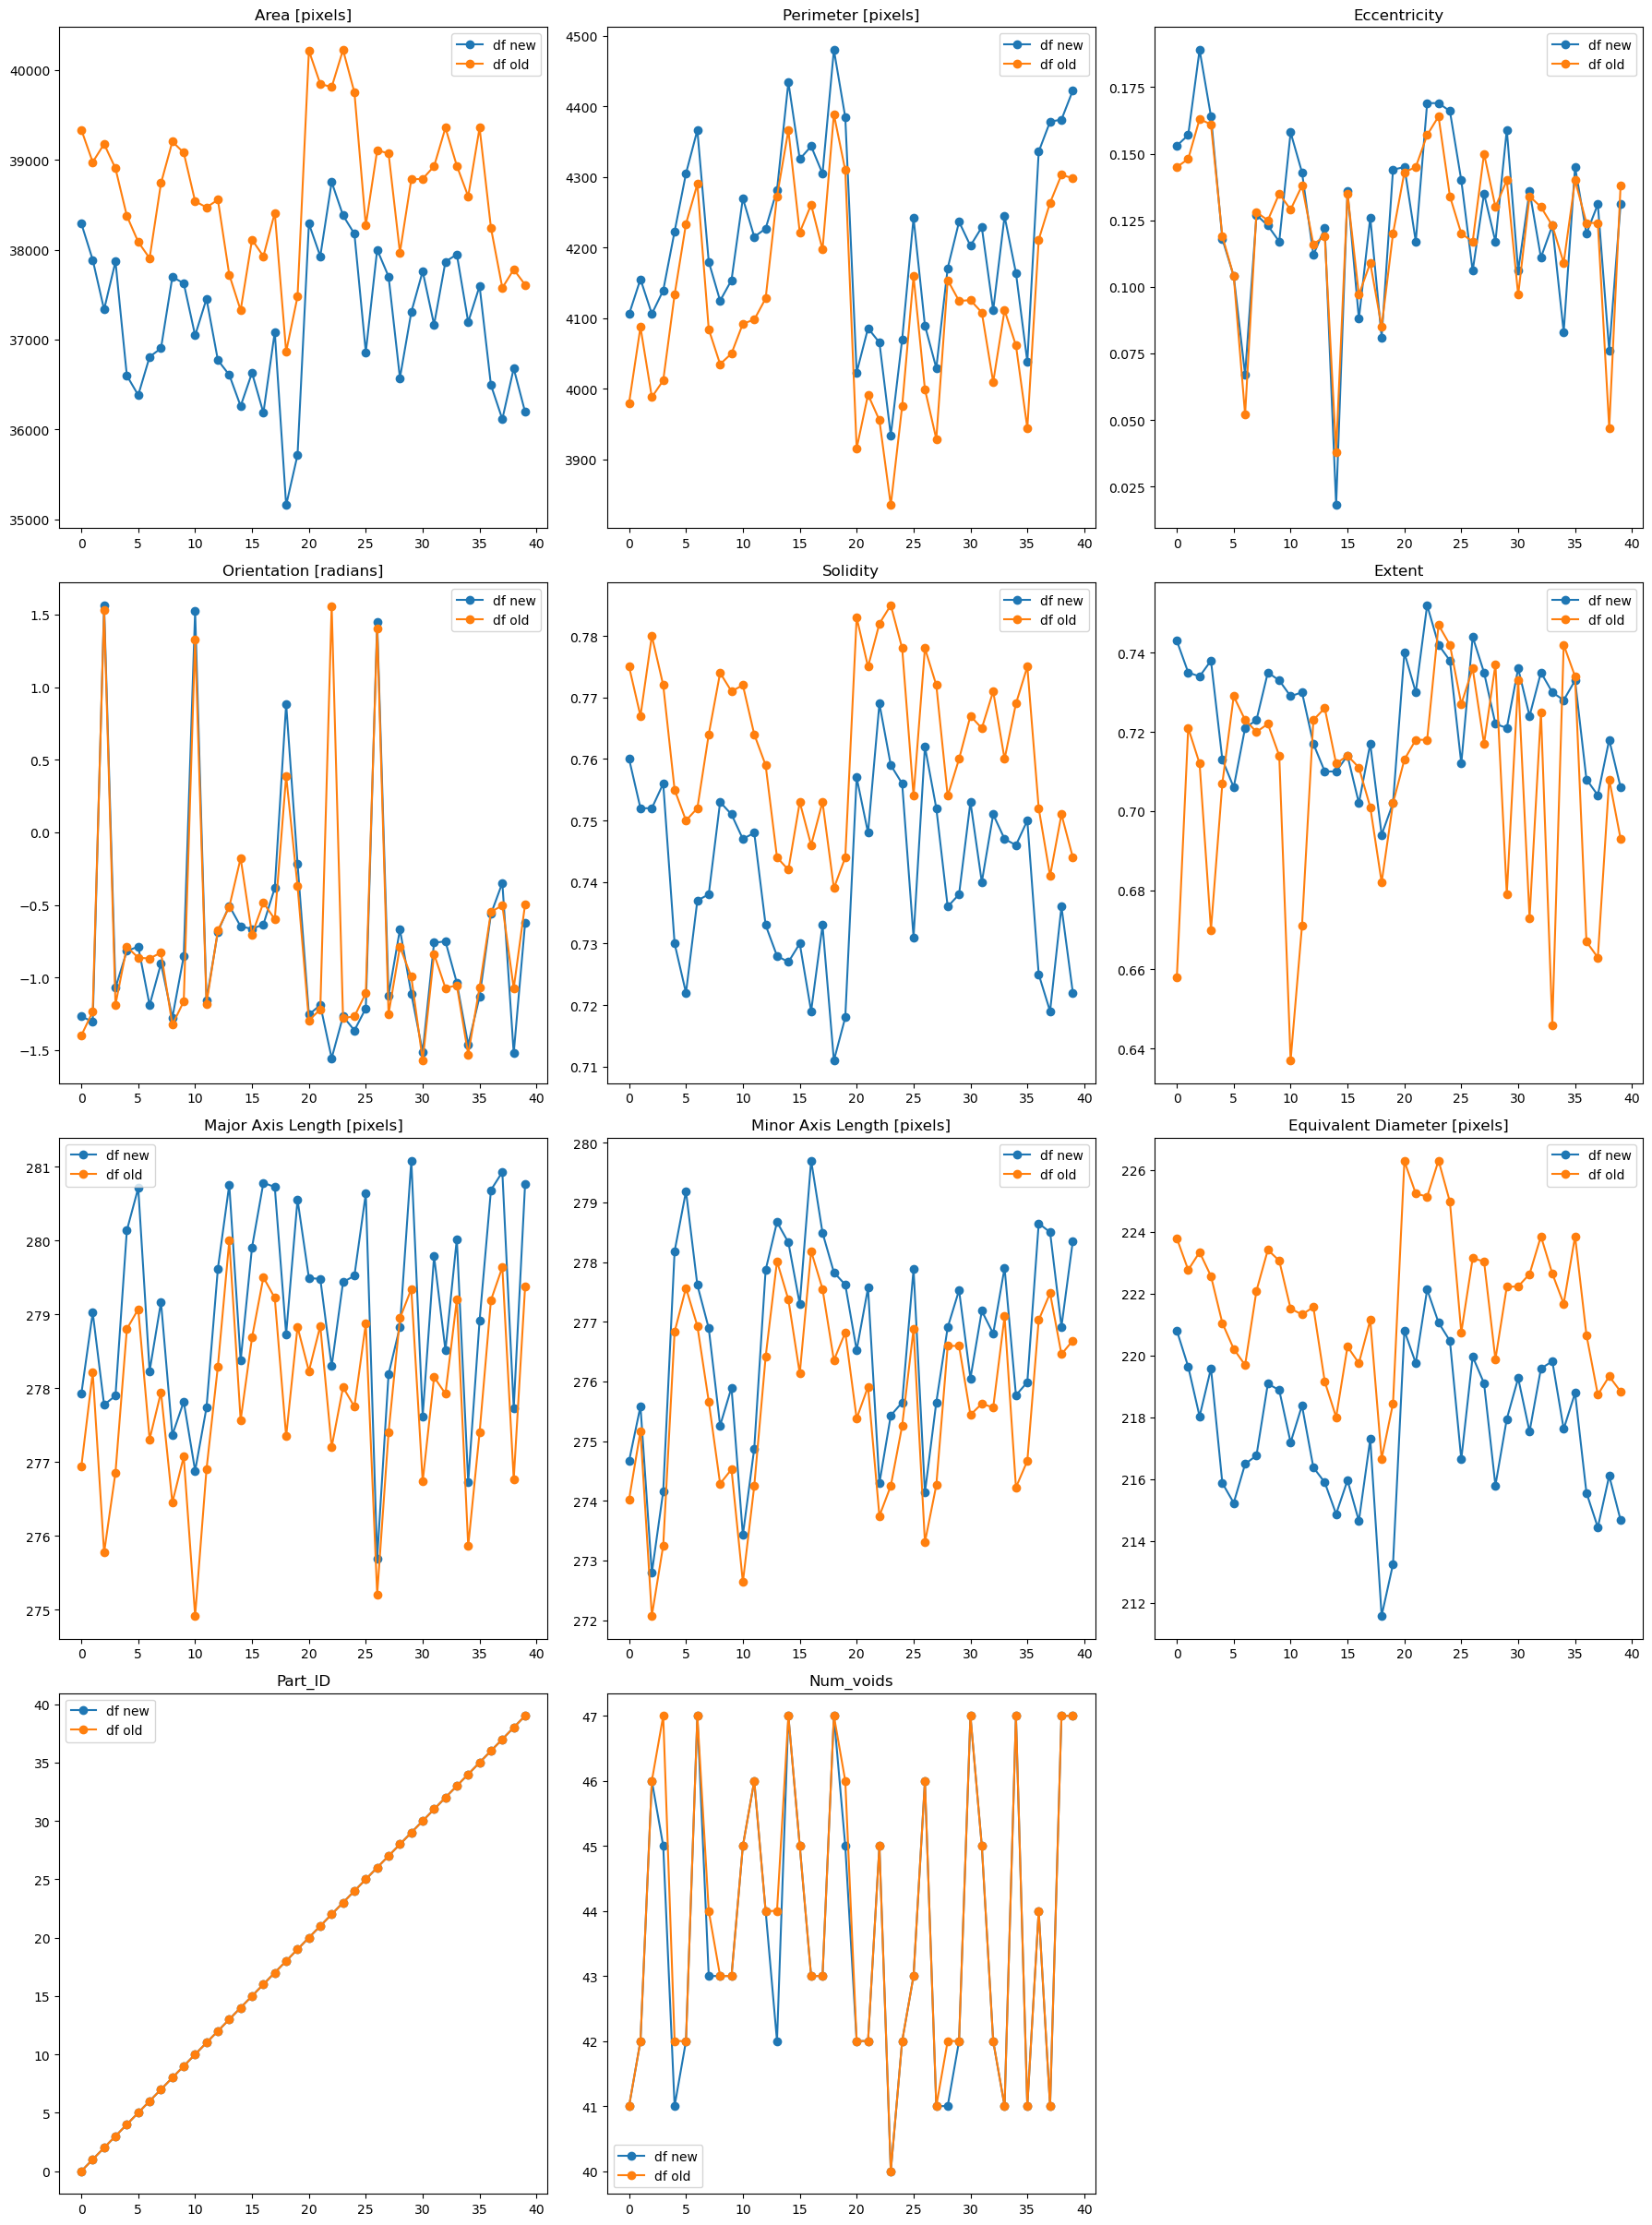

In [100]:
# comparing
meaningful_cols = len(df_new_parts.columns[4:])
num_rows = meaningful_cols // 3 + meaningful_cols % 3  # Calcola il numero di righe necessarie per i subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))  # Crea i subplot

for i, column in enumerate(df_new_parts.columns[4:]):
	row_index = i // 3
	col_index = i % 3

	axes[row_index, col_index].plot(df_new_parts[column],'o-', label='df new')
	axes[row_index, col_index].plot(df_old_parts[column],'o-', label='df old')

	axes[row_index, col_index].set_title(column)
	axes[row_index, col_index].legend()

fig.delaxes(axes[num_rows - 1, meaningful_cols % 3])
fig.delaxes(axes[num_rows - 2, meaningful_cols % 3])
fig.delaxes(axes[num_rows - 1, meaningful_cols % 3-1])
fig.delaxes(axes[num_rows - 1, meaningful_cols % 3-2])
plt.tight_layout()
plt.show()

# Datasets comparison
Through Nonparametric tests.

In [129]:
B = int(1e3)
results = []
start_index = 4
end_index = len(df_old_parts.columns) 

for col in df_old_parts.columns[start_index:end_index]:
    dataset1 = df_new_parts.loc[:, col].values # STAI RIMUOVENDO DATI 
    dataset2 = df_old_parts.loc[:, col].values

    dimD1 = dataset1.shape[0]
    dimD2 = dataset2.shape[0]
    min_dim = min(dimD1, dimD2)
    dataset1 = dataset1[:min_dim]
    dataset2 = dataset2[:min_dim]
    dataset = dataset1 - dataset2

    mu_hat = np.mean(dataset)
    sigma_hat = np.std(dataset)

    np.random.seed(42)
    t_boot = np.zeros(B)
    for b in range(B):
        x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
        mu_boot = np.mean(x_boot)
        sigma_boot = np.std(x_boot)
    
        t_boot[b] = (mu_boot - mu_hat) / sigma_boot

    ALPHA = 0.05
    q_low = np.percentile(t_boot, ALPHA/2 * 100)
    q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
    CI = {
        'Lower CI': mu_hat - q_up * sigma_hat,
        'Point Estimate': mu_hat,
        'Upper CI': mu_hat - q_low * sigma_hat
    }

    if (CI['Upper CI'] * CI['Lower CI'] > 0 ): # 0 not included 
        print(f"ATTENZIONE: L'intervallo di confidenza per la colonna {col} non contiene zero!")

    results.append([f"{col}", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))


ATTENZIONE: L'intervallo di confidenza per la colonna Area [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Perimeter [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Solidity non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Extent non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Major Axis Length [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Minor Axis Length [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Equivalent Diameter [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Num_voids non contiene zero!
+------------------------------+----------------+------------------+----------------+
| Column                       |       Lower CI |   Point Estimate |       Upper CI |
+==============================+================+==================+================+
| Area [pixels] 

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [130]:
B = int(1e3)
results = []
start_index = 4
end_index = len(df_old_voids.columns) 
diff = np.zeros(39)

# Definisci il range di immagini da 0 a 39
for img in range(40):

    # Itera sulle colonne del dataframe
    for col in df_old_voids.columns[start_index:end_index]:
        dataset1 = df_new_voids.loc[df_new_voids['Part_ID'] == img, col].values  # In teoria importa l'ordine perchè dovrei confrontare buco per buco, posso usare comunque t-boostrap? 
                                                                               # Io direi di sì ( test sulla media!! ) + STAI RIMUOVENDO DATI
        dataset2 = df_old_voids.loc[df_old_voids['Part_ID'] == img, col].values
        dimD1 = dataset1.shape[0]  # Assume che il numero di righe sia la dimensione rilevante
        dimD2 = dataset2.shape[0]
        min_dim = min(dimD1, dimD2)
        dataset1 = dataset1[:min_dim]
        dataset2 = dataset2[:min_dim]
        dataset = dataset1 - dataset2

        mu_hat = np.mean(dataset)
        sigma_hat = np.std(dataset)

        np.random.seed(42)
        t_boot = np.zeros(B)
        
        # Esegui il bootstrap
        for b in range(B):
            x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
            mu_boot = np.mean(x_boot)
            sigma_boot = np.std(x_boot)
    
            t_boot[b] = (mu_boot - mu_hat) / sigma_boot

        ALPHA = 0.05
        q_low = np.percentile(t_boot, ALPHA/2 * 100)
        q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
        CI = {
            'Lower CI': mu_hat - q_up * sigma_hat,
            'Point Estimate': mu_hat,
            'Upper CI': mu_hat - q_low * sigma_hat
        }

        if (CI['Upper CI'] * CI['Lower CI'] > 0 ): # 0 not included 
            print(f"ATTENZIONE: L'intervallo di confidenza per la colonna {col} non contiene zero!")
            diff[img] = 1 

        results.append([f"{col}\n(Part_ID = {img})", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

    print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))


ATTENZIONE: L'intervallo di confidenza per la colonna Solidity non contiene zero!


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


+------------------------------+-------------+------------------+--------------+
| Column                       |    Lower CI |   Point Estimate |     Upper CI |
+==============================+=============+==================+==============+
| Area [pixels]                | -27.3227    |      18.8049     |  63.3162     |
| (Part_ID = 0)                |             |                  |              |
+------------------------------+-------------+------------------+--------------+
| Perimeter [pixels]           |  -3.93578   |       3.15383    |   9.72439    |
| (Part_ID = 0)                |             |                  |              |
+------------------------------+-------------+------------------+--------------+
| Eccentricity                 |  -0.0363188 |      -0.00497561 |   0.0276549  |
| (Part_ID = 0)                |             |                  |              |
+------------------------------+-------------+------------------+--------------+
| Orientation [radians]     

Boostrap t-intervals and standard CI for df_parts_new

In [131]:
# Boostrap 
B = int(1e3)
results = []
start_index = 4
end_index = len(df_new_parts.columns) 

for col in df_new_parts.columns[start_index:end_index]:
    dataset = df_new_parts.loc[:, col].values

    mu_hat = np.mean(dataset)
    sigma_hat = np.std(dataset)

    np.random.seed(42)
    t_boot = np.zeros(B)
    for b in range(B):
        x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
        mu_boot = np.mean(x_boot)
        sigma_boot = np.std(x_boot)
    
        t_boot[b] = (mu_boot - mu_hat) / sigma_boot

    ALPHA = 0.05
    q_low = np.percentile(t_boot, ALPHA/2 * 100)
    q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
    CI = {
        'Lower CI': mu_hat - q_up * sigma_hat,
        'Point Estimate': mu_hat,
        'Upper CI': mu_hat - q_low * sigma_hat
    }

    results.append([f"{col}", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))
## AREA AND Num_Wpixels ARE THE SAME THING 


+------------------------------+--------------+------------------+--------------+
| Column                       |     Lower CI |   Point Estimate |     Upper CI |
+==============================+==============+==================+==============+
| Area [pixels]                | 36921.3      |      37182.1     | 37434.7      |
+------------------------------+--------------+------------------+--------------+
| Perimeter [pixels]           |  4174.05     |       4214.57    |  4254.74     |
+------------------------------+--------------+------------------+--------------+
| Eccentricity                 |     0.115212 |          0.1258  |     0.135312 |
+------------------------------+--------------+------------------+--------------+
| Orientation [radians]        |    -0.939147 |         -0.73485 |    -0.344891 |
+------------------------------+--------------+------------------+--------------+
| Solidity                     |     0.736739 |          0.74105 |     0.745641 |
+---------------

Bonferroni CI

In [137]:
# Since Area, Perimeter, Eccentricity, Solidity, Extent, Major Axis Length,  Minor Axis Length, Equivalent Diameter, Num_Wpixels, Num_Bpixels, Wpixels_ratio are normal we can built the t-di-student CI
# We want an significant level of 0.05 in total, so we can built the Bonferroni CI

## AREA AND Num_Wpixels ARE THE SAME THING -> I CONSIDER ONLY THE AREA
 
from scipy.stats import f
from scipy.stats import t

data_parts_normal  = np.column_stack((
    df_new_parts['Area [pixels]'],
    df_new_parts['Perimeter [pixels]'],
    df_new_parts['Eccentricity'],
    df_new_parts['Solidity'],
    df_new_parts['Extent'],
    df_new_parts['Major Axis Length [pixels]'],
    df_new_parts['Minor Axis Length [pixels]'],
    df_new_parts['Equivalent Diameter [pixels]'],
    # df_new_parts['Num_Bpixels'], # new variables we added but in the end removed
    #df_new_parts['Num_Wpixels'], # new variables we added but in the end removed
    # df_new_parts['Wpixels_ratio'] # new variables we added but in the end removed
))

## AREA AND Num_Wpixels ARE THE SAME THING

column_names = [
    'Area',
    'Perimeter',
    'Eccentricity',
    'Solidity',
    'Extent',
    'Major Axis Length',
    'Minor Axis Length',
    'Equivalent Diameter',
    # 'Num_Bpixels', # new variables we added but in the end removed
    #'Num_Wpixels', # new variables we added but in the end removed
    # 'Wpixels_ratio' # new variables we added but in the end removed
]

# Creating DataFrame
df_parts_normal = pd.DataFrame(data_parts_normal, columns=column_names)

# Assuming 'dataset' is your DataFrame
# Dimensions
n = df_parts_normal.shape[0]
p = df_parts_normal.shape[1]
alpha = 0.05  # At level 5%

# Sample mean, covariance
x_mean = np.mean(df_parts_normal, axis = 0)
x_cov = np.cov(df_parts_normal, rowvar=False)
x_invcov = np.linalg.inv(x_cov)
cfr_fisher = ((n - 1) * p / (n - p)) * f.ppf(1 - alpha, p, n - p)

mu0 = np.array([0] * p)

# Bonferroni (for the difference) confidence intervals
k = p  # number of intervals I want to compute (set in advance)

cfr_t = t.ppf(1 - alpha / (2 * k), n - 1)
Bf = np.column_stack((
    x_mean - mu0 - cfr_t * np.sqrt(np.diag(x_cov) / n),
    x_mean - mu0,
    x_mean - mu0 + cfr_t * np.sqrt(np.diag(x_cov) / n)
))
Bf

### NB non cambiano così tanto...

array([[3.68134101e+04, 3.71821250e+04, 3.75508399e+04],
       [4.15526917e+03, 4.21457357e+03, 4.27387798e+03],
       [1.10904334e-01, 1.25800000e-01, 1.40695666e-01],
       [7.34488184e-01, 7.41050000e-01, 7.47611816e-01],
       [7.17701990e-01, 7.24100000e-01, 7.30498010e-01],
       [2.78441335e+02, 2.79064350e+02, 2.79687365e+02],
       [2.75939556e+02, 2.76700800e+02, 2.77462044e+02],
       [2.16488601e+02, 2.17569000e+02, 2.18649399e+02]])

In [138]:
## boostrap t intervals for df_new_voids after computing the mean for each image

B = int(1e3)
results = []

start_index = 4

end_index = len(df_new_voids.columns) 

diff = np.zeros(39)
avgdataset = np.empty((0, df_new_voids.columns[start_index:end_index].shape[0]))  # num_columns should be the number of columns in your dataset


# Definisci il range di immagini da 0 a 39
for img in range(40):

    dataset = df_new_voids.loc[df_new_voids['Part_ID'] == img, df_new_voids.columns[start_index:end_index]].values      
    avg = np.mean(dataset, axis = 0)
    avgdataset = np.vstack((avgdataset, avg))


column_names = df_new_voids.columns[start_index:end_index].tolist()

avgdataset = pd.DataFrame(avgdataset, columns= column_names)


# Itera sulle colonne del dataframe
for col in df_new_voids.columns[start_index:end_index]:
    dataset = avgdataset.loc[:,col].values  

    mu_hat = np.mean(dataset)
    sigma_hat = np.std(dataset)

    np.random.seed(42)
    t_boot = np.zeros(B)
        
     # Esegui il bootstrap
    for b in range(B):
        x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
        mu_boot = np.mean(x_boot)
        sigma_boot = np.std(x_boot)
    
        t_boot[b] = (mu_boot - mu_hat) / sigma_boot

    ALPHA = 0.05
    q_low = np.percentile(t_boot, ALPHA/2 * 100)
    q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
    CI = {
        'Lower CI': mu_hat - q_up * sigma_hat,
        'Point Estimate': mu_hat,
        'Upper CI': mu_hat - q_low * sigma_hat
        }

    results.append([f"{col}", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))


+------------------------------+------------+------------------+------------+
| Column                       |   Lower CI |   Point Estimate |   Upper CI |
+==============================+============+==================+============+
| Area [pixels]                | 285.843    |       292.449    | 298.816    |
+------------------------------+------------+------------------+------------+
| Perimeter [pixels]           |  69.56     |        70.696    |  71.8184   |
+------------------------------+------------+------------------+------------+
| Eccentricity                 |   0.81815  |         0.824125 |   0.829432 |
+------------------------------+------------+------------------+------------+
| Orientation [radians]        |   0.108643 |         0.128994 |   0.15297  |
+------------------------------+------------+------------------+------------+
| Solidity                     |   0.913952 |         0.91691  |   0.919453 |
+------------------------------+------------+------------------+

# New variables

## adding curvature

In [159]:
curvatures_mean = np.zeros(n_objects)

for part_id in range(n_objects):

	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)
	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	img_with_contours = img.copy()

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		# print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)
		# print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		edged = cv2.Canny(rot_image, 30, 200)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
		contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE )
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
		largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# reconnect end with begin points
	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)

	x_coords = [point[0] for point in contours_points]
	y_coords = [point[1] for point in contours_points]
	curvature = calculate_curvature(contours_points)

	# curvatures_mean[part_id] = np.max(np.abs(curvature))+np.mean(curvature)
	curvatures_mean[part_id] = np.mean(curvature)

summary_assumptions(curvatures_mean,"Curvature Mean")
df_new_parts["Curvature Mean"] = curvatures_mean

(Curvature Mean) Normality p-value = 0.5501565337181091 - Normality at alpha 5%? True
(Curvature Mean) Runs test p-value = 0.5217024890869293 - Random data at alpha 5%? True


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## adding max void perimeter

In [160]:
biggest_void_perimeter = np.zeros(40)
for pid in range(0,40):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	biggest_void_perimeter[pid] = np.max(img_df["Perimeter [pixels]"])
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

df_new_parts["Max Void Perimeter"] = biggest_void_perimeter

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## adding max void area

In [161]:
biggest_void_areas = np.zeros(40)
for pid in range(0,40):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	biggest_void_areas[pid] = np.max(img_df["Area [pixels]"])
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

df_new_parts["Max Void Area"] = biggest_void_areas

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## adding white pixels ratio

In [169]:
def count_pixels(pid):
	# same code of the df_new generation procedure
	image_path = genera_percorso_immagine(pid, "rot&crop")
	image = Image.open(image_path)
	image = image.convert('L')
	enhancer = ImageEnhance.Contrast(image)
	image = enhancer.enhance(100)
	image = np.array(image)
	otsu_thresh = threshold_otsu(image)
	image = image > otsu_thresh

	shape = np.shape(image)
	num_white_pixels = np.sum(image)
	num_black_pixels = (image == 0).sum()

	assert num_white_pixels + num_black_pixels == shape[0] * shape[1]
	return num_white_pixels, num_black_pixels

def pixels_ratio(pid):
	# we return #white pixels / #tot image pixels
	white_pixels = count_pixels(pid)[0]
	image_path = genera_percorso_immagine(pid, "rot&crop")
	image = Image.open(image_path)
	shape = np.shape(image)
	tot_pixels = shape[0]*shape[1]
	return white_pixels/tot_pixels

df_new_parts['White Pixels Ratio'] = df_new_parts['Part_ID'].apply(lambda x: pixels_ratio(x))

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Visualizations

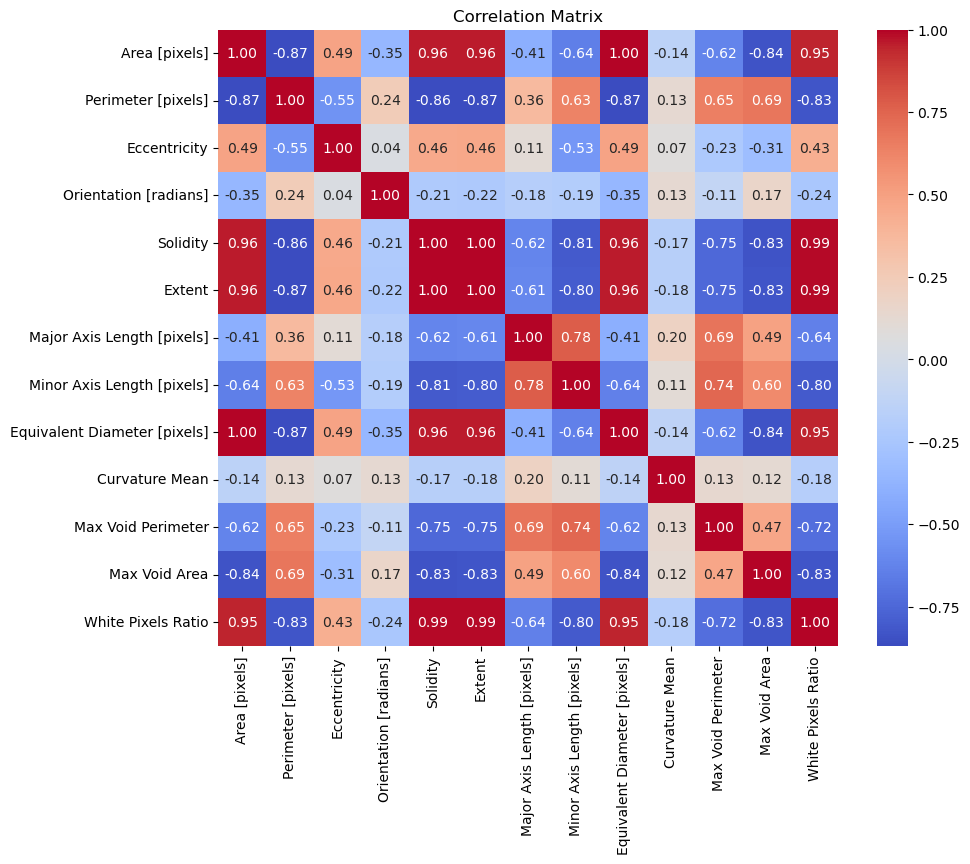

In [170]:
data = df_new_parts.copy()
data = data.drop(columns=["ID","Part_ID","Num_voids"])
cor_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Normality assumption

In [164]:
for col in df_new_parts.columns[4:]:
	summary_assumptions(df_new_parts[col],col,0)
	print("")

(Area [pixels]) Normality p-value = 0.7310476303100586 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.024927044113953436 - Random data at alpha 5%? False

(Perimeter [pixels]) Normality p-value = 0.8690754771232605 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 0.025599049061790877 - Random data at alpha 5%? False

(Eccentricity) Normality p-value = 0.09720978140830994 - Normality at alpha 5%? True
(Eccentricity) Runs test p-value = 0.1933261617649059 - Random data at alpha 5%? True

(Orientation [radians]) Normality p-value = 9.760273087522364e-07 - Normality at alpha 5%? False
(Orientation [radians]) Runs test p-value = 0.049028818261799306 - Random data at alpha 5%? False

(Solidity) Normality p-value = 0.26717373728752136 - Normality at alpha 5%? True
(Solidity) Runs test p-value = 0.0039358900854266484 - Random data at alpha 5%? False

(Extent) Normality p-value = 0.3694446086883545 - Normality at alpha 5%? True
(Extent) Runs test p-val

In [ ]:
# Shapiro-Wilk test
_, p_value_SW = stats.shapiro(data)
print('p-value of the Shapiro-Wilk test for "{}": {:.3f}'.format(col, float(p_value_SW)))

Selection

In [150]:
#useful plots 
#used them iteratively to look at all variable disposition graphically
#here only examples

plt.plot(df_new_parts['Part_ID'], df_new_parts['Equivalent Diameter [pixels]'], 'o')
plt.hist(df_new_parts['Eccentricity'], color='skyblue', edgecolor='black')

In [ ]:
# Not normal
data_part_norm = data.drop(columns=['Orientation [radians]','Num_voids','Num_Wpixels'])  # remove also Num_Wpixels, same info of Area

In [ ]:
data_part_norm.corr()

In [ ]:
data_part_norm = data_part_norm.drop(columns=['Solidity','Extent' ,'Num_Bpixels', 'ID'])  
data_part_norm = data_part_norm.drop(columns=['Equivalent Diameter [pixels]'])

In [ ]:
data_part_norm.head(10)

In [ ]:
dataNum = data_part_norm.select_dtypes(include=np.number)
dataset=dataNum.drop(columns=['Part_ID'])  # remove also Num_Wpixels, same info of Area
dataset.head(10)

In [ ]:
#Scatter plot
pd.plotting.scatter_matrix(dataset)
plt.show()

# can see some linear correlated vars and some very sparse/uncorrelated

## PCA

In [ ]:
# Correlation matrix
cov_matrix = dataset.cov()
#print(cov_matrix)

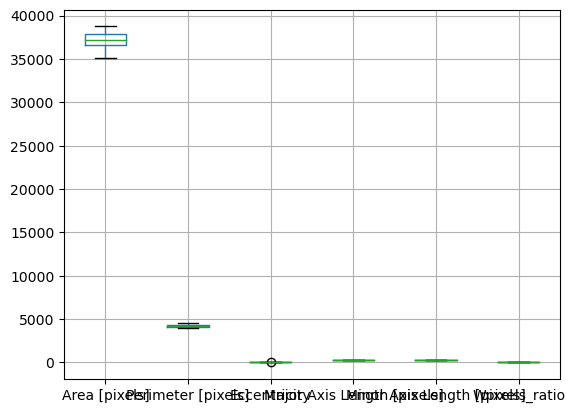

In [ ]:
#Boxplot
dataset.boxplot()
plt.show() 
# need to scale vars

In [ ]:
# Standardize the data
data_std = (dataset - dataset.mean()) / dataset.std()
data_std.head(10)

Area [pixels]  Perimeter [pixels]  Eccentricity  \
0       1.374602           -0.839314      0.834630   
1       0.873789           -0.456789      0.957370   
2       0.188270           -0.836215      1.939288   
3       0.850236           -0.580004      1.172164   
4      -0.722863            0.064983     -0.239342   
5      -0.991864            0.697615     -0.668932   
6      -0.463779            1.171270     -1.804274   
7      -0.346014           -0.266204      0.036822   
8       0.638258           -0.692522     -0.085918   
9       0.550244           -0.468141     -0.270027   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  Wpixels_ratio  
0                   -0.835879                   -1.221151       1.381585  
1                   -0.028135                   -0.670558       0.828088  
2                   -0.944459                   -2.347555       0.522110  
3                   -0.854220                   -1.526769       1.259156  
4                    0.789146                    0.889354      -0.937490  
5                    1.210992                    1.492785      -1.234783  
6                   -0.609916                    0.550112      -0.205883  
7                    0.076776                    0.114802      -0.521005  
8                   -1.244520                   -0.865698       0.794300  
9                   -0.912912                   -0.482624       0.696600

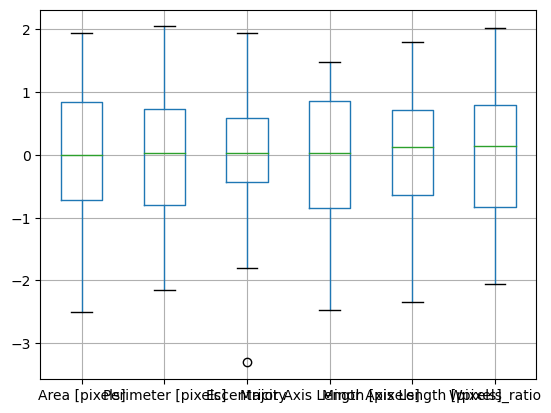

In [ ]:
#cov matrix
cov_matrix_std = data_std.cov()

#Boxplot
data_std.boxplot()
plt.show() 

In [ ]:
# Create the PCA object
pca = PCA()
# Fit the PCA object to the data
pca.fit(data_std)

#print("Eigenvalues \n", pca.explained_variance_)
#print("\nEigenvectors \n", pca.components_)
#print("\nExplained variance ratio \n", pca.explained_variance_ratio_)

print("\nCumulative explained variance ratio \n", np.cumsum(pca.explained_variance_ratio_))



Cumulative explained variance ratio 
 [0.67590644 0.87491069 0.97001165 0.99673013 0.99860071 1.        ]


In [ ]:
# Compute the scores (i.e. all the principal components, n x 3) 
scores = pca.transform(data_std)
# create a dataframe with the scores
scores_df = pd.DataFrame(scores)
# Print the first rows of the scores dataframe
scores_df.head()

0         1         2         3         4         5
0 -2.689999  0.011667  0.083255  0.378495 -0.028809 -0.044899
1 -1.568524 -0.623291  0.168152  0.383475 -0.002288  0.028256
2 -2.581500 -0.316555  2.043866 -0.410732 -0.221245  0.108483
3 -2.516162 -0.018588  0.786891  0.331527  0.084378  0.108729
4  1.513406 -0.520160 -0.217246 -0.516617 -0.005043 -0.039359

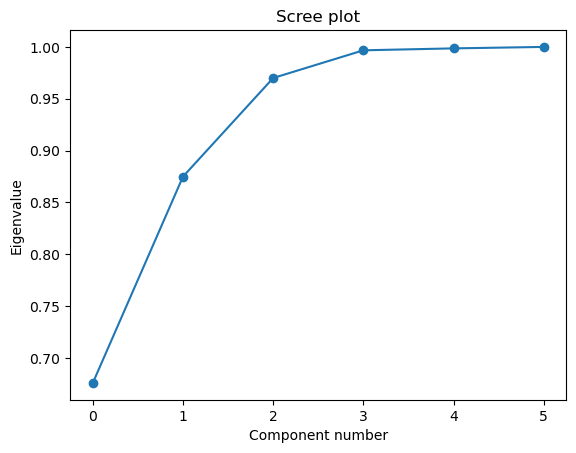

In [ ]:
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
plt.show()

# keeping 4 or 5 pcs should be enough (more than 95% variability explained)

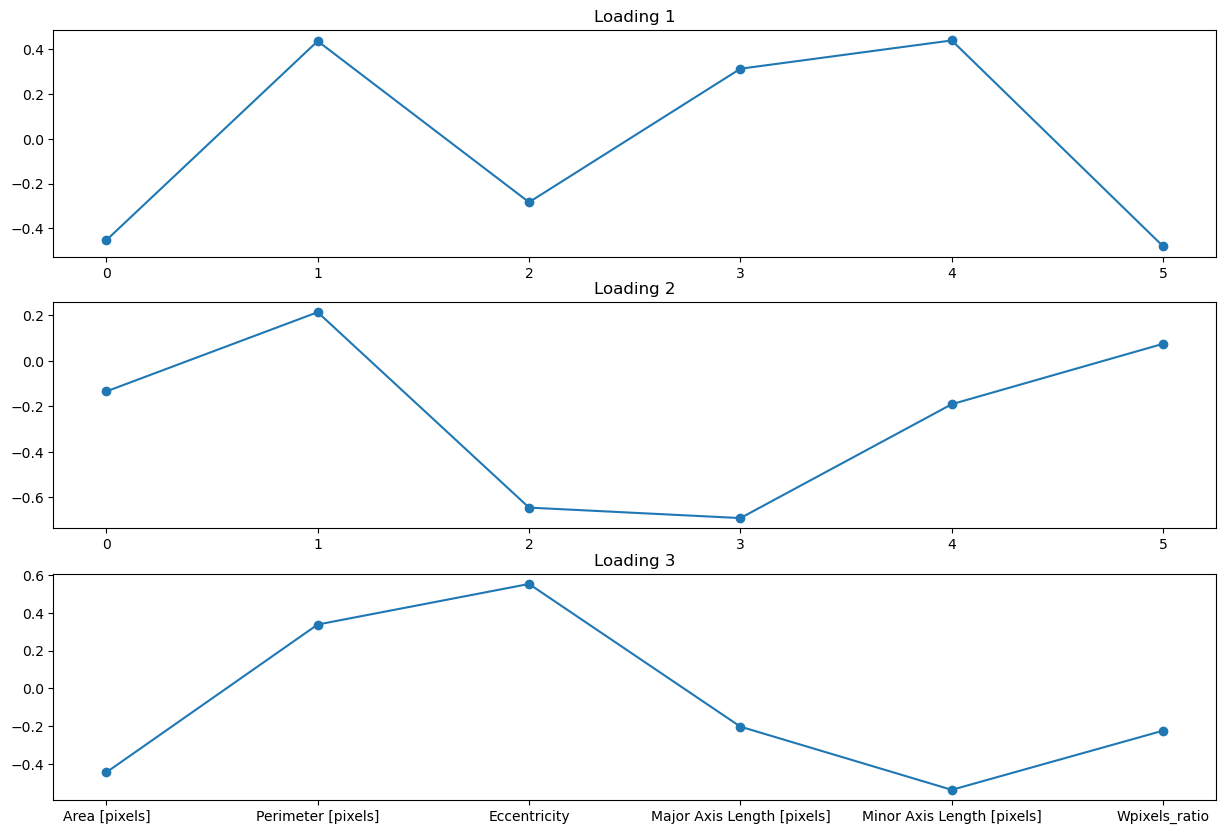

In [ ]:
# Loadings
# Plot only the first k PCs
k = 3
fig, ax = plt.subplots(k,1, figsize = (15, 10))
for i in range(k):
   ax[i].plot(pca.components_[i], 'o-')
   ax[i].set_title('Loading ' + str(i+1))
   plt.xticks(ticks=np.arange(0, 6, step=1), labels=dataset.columns)


In [ ]:
# PCs normality
for col in scores_df.columns:
    dataset = scores_df.loc[:, col].values
    _, p_value_SW = stats.shapiro(dataset)
    print('p-value of the Shapiro-Wilk test for "{}": {:.3f}'.format(col, float(p_value_SW)))

#some normal, some not
#we interested in 0 to 4, but "1" and "2" not normal 


p-value of the Shapiro-Wilk test for "0": 0.069
p-value of the Shapiro-Wilk test for "1": 0.008
p-value of the Shapiro-Wilk test for "2": 0.007
p-value of the Shapiro-Wilk test for "3": 0.310
p-value of the Shapiro-Wilk test for "4": 0.001
p-value of the Shapiro-Wilk test for "5": 0.010


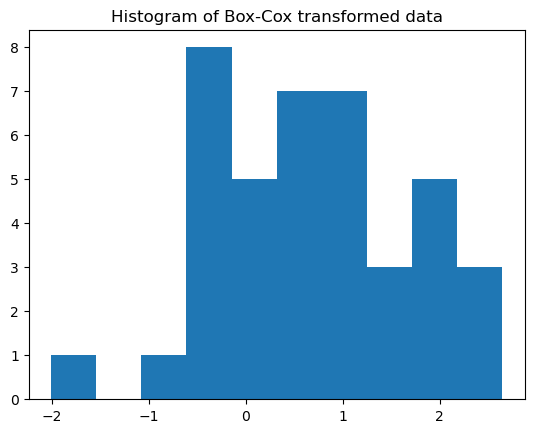

p-value of the Shapiro-Wilk test for "transf_1": 0.578


In [ ]:
# Box-Cox 
dat = scores_df.loc[:, 1].values
dat=dat+np.abs(dat.min())+0.001
[transf_1, lmbda] = stats.boxcox(dat) 
# If lmbda is None (default), find the value of lmbda that maximizes the log-likelihood function and return it as the second output argument.

plt.hist(transf_1)
plt.title('Histogram of Box-Cox transformed data')
plt.show()

col = 'transf_1'
_, p_value_SW = stats.shapiro(transf_1)
print('p-value of the Shapiro-Wilk test for "{}": {:.3f}'.format(col, float(p_value_SW)))

# normal

## Randomness

In [ ]:
# even if we don't think time is involved...

In [ ]:
for col in dataset.columns:
   _, pval_runs = runstest_1samp(dataset[col], correction=False)
   print('Runs test p-value for', col ,' = {:.3f}'.format(pval_runs))
   if pval_runs<0.05:
     print('The null hypothesis is rejected: the process is not random')
   else:
     print('The null hypothesis is accepted: the process is random')

Runs test p-value for Area [pixels]  = 0.025
The null hypothesis is rejected: the process is not random
Runs test p-value for Perimeter [pixels]  = 0.026
The null hypothesis is rejected: the process is not random
Runs test p-value for Eccentricity  = 0.193
The null hypothesis is accepted: the process is random
Runs test p-value for Major Axis Length [pixels]  = 0.749
The null hypothesis is accepted: the process is random
Runs test p-value for Minor Axis Length [pixels]  = 0.032
The null hypothesis is rejected: the process is not random
Runs test p-value for Wpixels_ratio  = 0.004
The null hypothesis is rejected: the process is not random
Runs test p-value for Curvature Mean  = 0.522
The null hypothesis is accepted: the process is random


# SPCs

## Idea 2: bypass indipendence test

In [171]:
df_new_parts.columns

Index(['Image name', 'Position', 'Region type', 'ID', 'Area [pixels]',
       'Perimeter [pixels]', 'Eccentricity', 'Orientation [radians]',
       'Solidity', 'Extent', 'Major Axis Length [pixels]',
       'Minor Axis Length [pixels]', 'Equivalent Diameter [pixels]', 'Part_ID',
       'Num_voids', 'Curvature Mean', 'Max Void Perimeter', 'Max Void Area',
       'White Pixels Ratio'],
      dtype='object')

In [176]:
candidate_variables = ["Area [pixels]", "White Pixels Ratio", "Perimeter [pixels]", "Major Axis Length [pixels]", 'Curvature Mean', 'Max Void Perimeter', 'Max Void Area']
for relvar in candidate_variables:
	summary_assumptions(df_new_parts[relvar],relvar,0)
	print()

(Area [pixels]) Normality p-value = 0.7310476303100586 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.024927044113953436 - Random data at alpha 5%? False

(White Pixels Ratio) Normality p-value = 0.350693941116333 - Normality at alpha 5%? True
(White Pixels Ratio) Runs test p-value = 0.0039358900854266484 - Random data at alpha 5%? False

(Perimeter [pixels]) Normality p-value = 0.8690754771232605 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 0.025599049061790877 - Random data at alpha 5%? False

(Major Axis Length [pixels]) Normality p-value = 0.09676539897918701 - Normality at alpha 5%? True
(Major Axis Length [pixels]) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Curvature Mean) Normality p-value = 0.5501565337181091 - Normality at alpha 5%? True
(Curvature Mean) Runs test p-value = 0.5217024890869293 - Random data at alpha 5%? True

(Max Void Perimeter) Normality p-value = 0.9064947962760925 - Normality at al

In [246]:
chosen_variables = [
	"Area [pixels]",
	# chose one of these two
	"White Pixels Ratio",

	"Perimeter [pixels]",
	"Major Axis Length [pixels]",
	'Curvature Mean',
	'Max Void Perimeter',
	'Max Void Area']
seed = 42
df_shuffled = df_new_parts.sample(frac=1,random_state=seed).reset_index(drop=True)

In [247]:
for chosvar in chosen_variables:
	summary_assumptions(df_shuffled[chosvar],chosvar,0)
	print()

(Area [pixels]) Normality p-value = 0.7310476303100586 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.5217024890869293 - Random data at alpha 5%? True

(White Pixels Ratio) Normality p-value = 0.350693941116333 - Normality at alpha 5%? True
(White Pixels Ratio) Runs test p-value = 0.5217024890869293 - Random data at alpha 5%? True

(Perimeter [pixels]) Normality p-value = 0.8690754771232605 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 0.5102613793829918 - Random data at alpha 5%? True

(Major Axis Length [pixels]) Normality p-value = 0.09676539897918701 - Normality at alpha 5%? True
(Major Axis Length [pixels]) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Curvature Mean) Normality p-value = 0.5501565337181091 - Normality at alpha 5%? True
(Curvature Mean) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Max Void Perimeter) Normality p-value = 0.9064947962760925 - Normality at alpha 5%? Tr

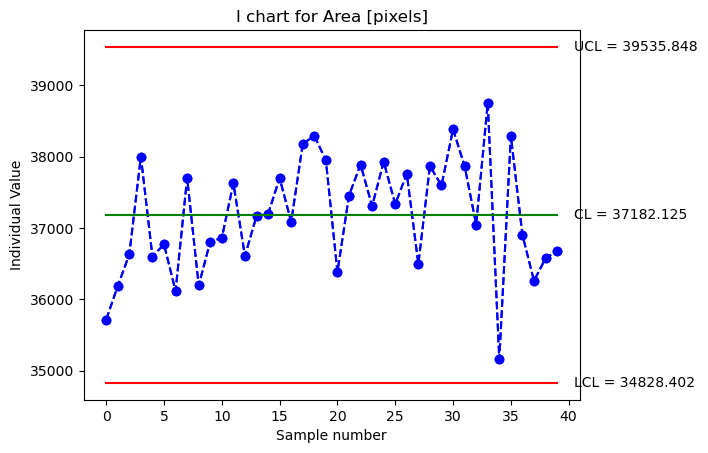

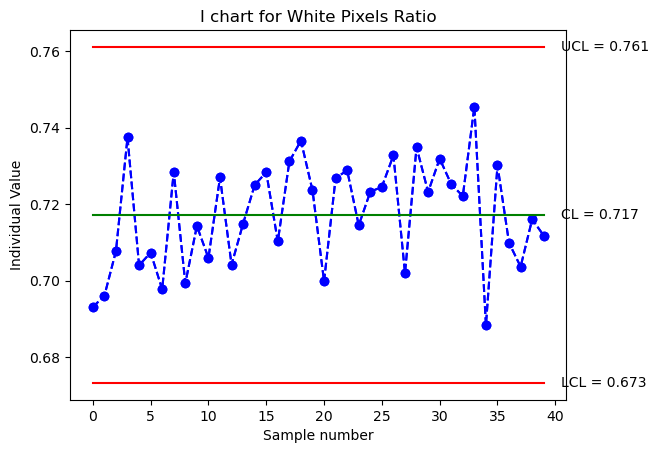

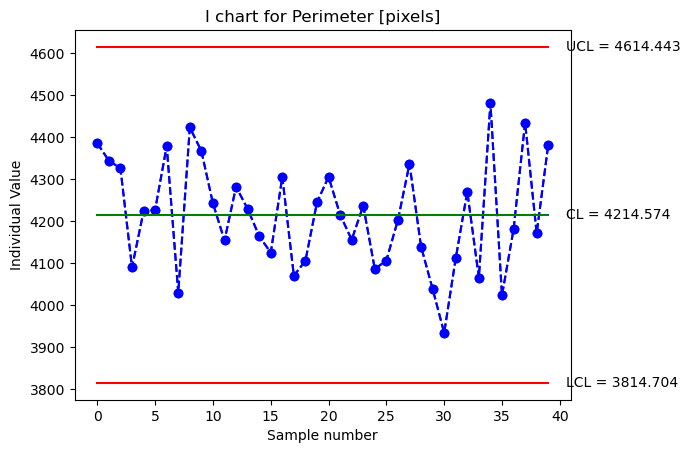

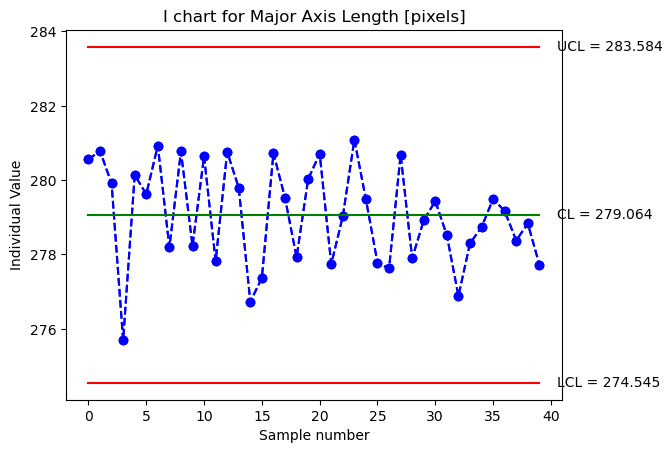

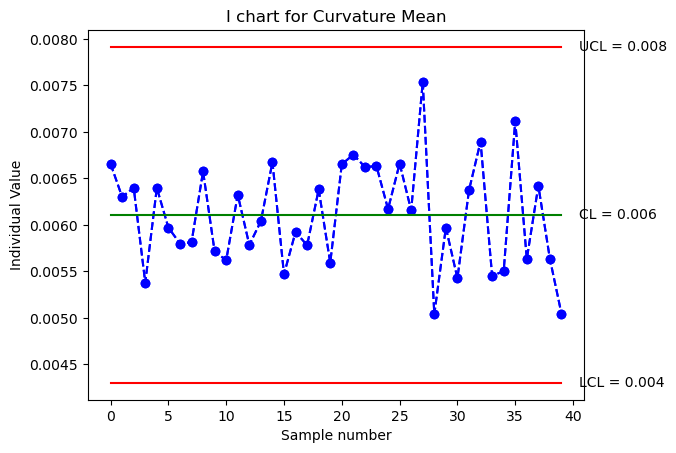

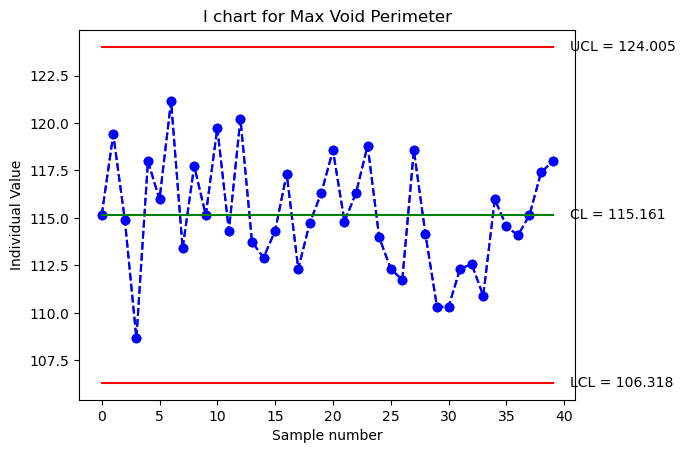

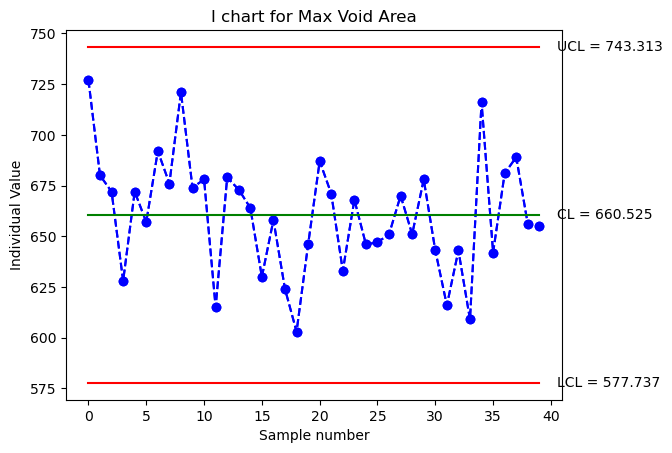

In [250]:
# manually and just the I one
d2 = 1.128
for chosvar in chosen_variables:
	df = pd.DataFrame(df_shuffled[chosvar])
	df['MR'] = df[chosvar].diff().abs()
	df['I_UCL'] = df[chosvar].mean() + (3*df['MR'].mean()/d2)
	df['I_CL'] = df[chosvar].mean()
	df['I_LCL'] = df[chosvar].mean() - (3*df['MR'].mean()/d2)
	df['I_TEST1'] = np.where((df[chosvar] > df['I_UCL']) |
	(df[chosvar] < df['I_LCL']), df[chosvar], np.nan)
	# df.head()

	# Plot the I chart
	plt.title(f'I chart for {chosvar}')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df['I_UCL'], color='r')
	plt.plot(df['I_CL'], color='g')
	plt.plot(df['I_LCL'], color='r')
	plt.ylabel('Individual Value')
	plt.xlabel('Sample number')
	# add the values of the control limits on the right side of the plot
	plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.3f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
	plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.3f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
	plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.3f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
	# highlight the points that violate the alarm rules
	plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
	plt.show()

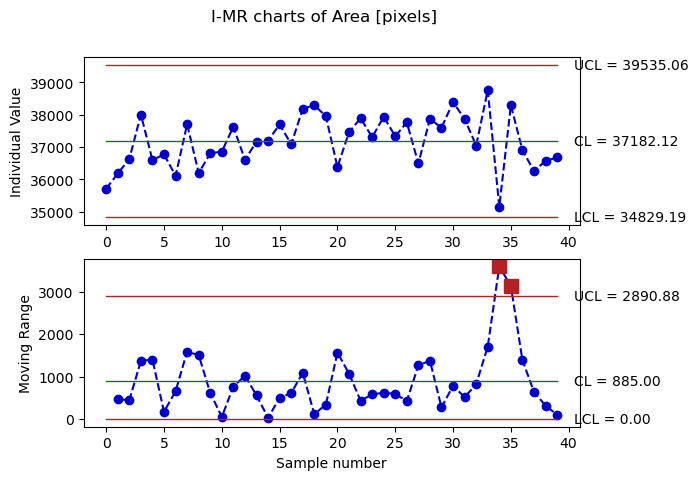

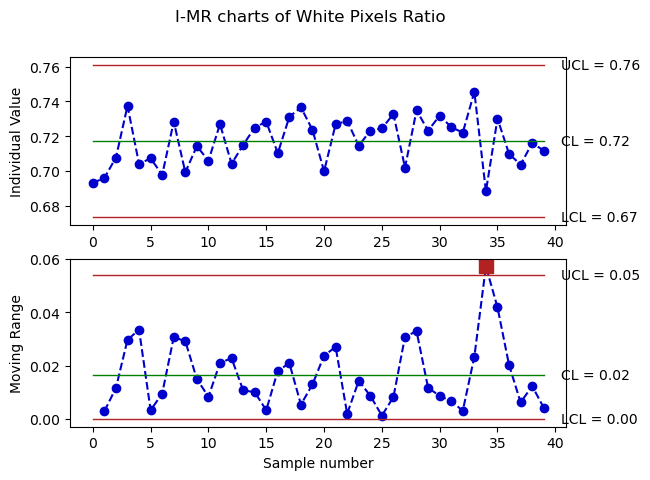

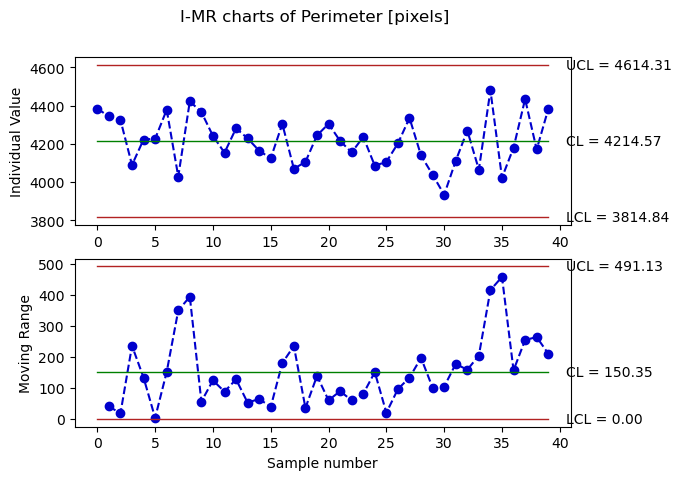

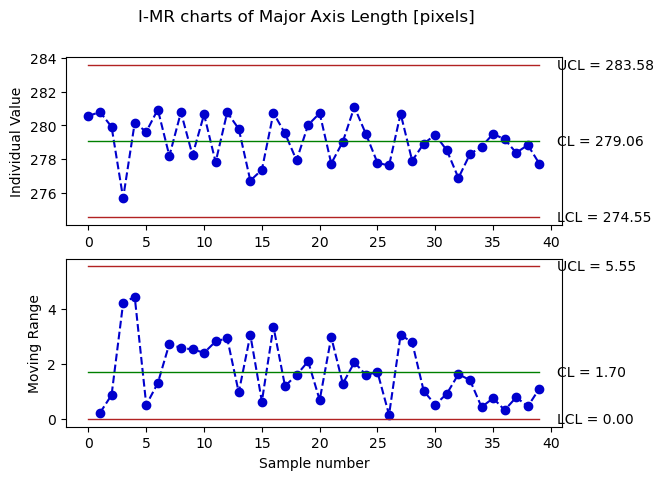

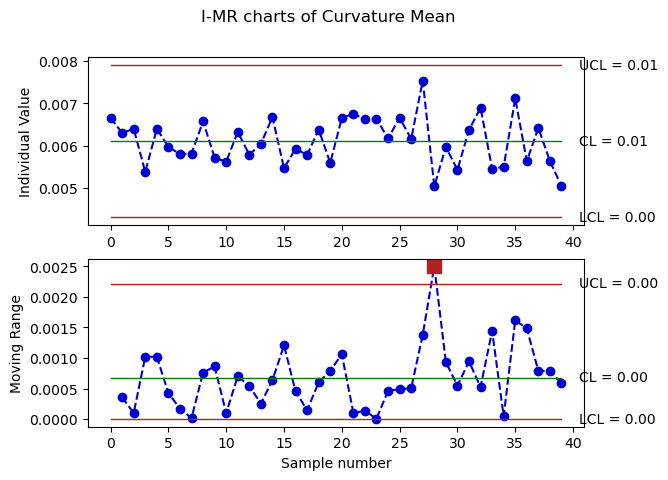

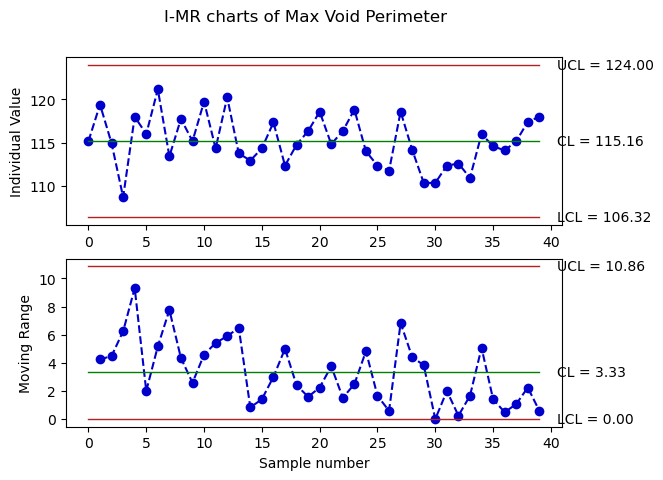

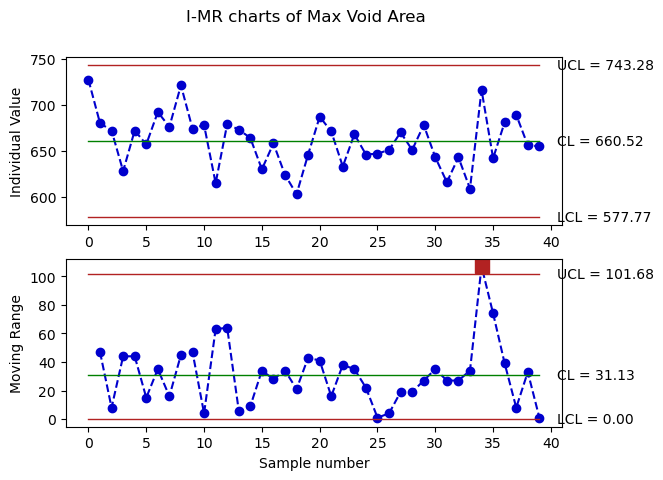

In [249]:
for chosvar in chosen_variables:
	data=pd.DataFrame(df_shuffled[chosvar])
	data_IMR = qda.ControlCharts.IMR(data,chosvar)